# Modulos

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os


In [11]:
#notebook_path = os.path.abspath("./Python/variations.xls")


# Tratamento de Dados

Criar data frame e colocar primeira coluna como sample

In [17]:
raw_data = pd.read_excel(
    "../Python/variations.xls", sheet_name="variations")
    #"./projects/covid/variations.xls", sheet_name="variations")

raw_df = pd.DataFrame(raw_data)
raw_df.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)
raw_df

,sample,REF,ALT,#
0,sample_5390,NaN,NaN,NaN
1,NaN,A,G,1.0
2,NaN,C,T,4.0
3,NaN,GGG,AAC,1.0
4,sample_5391,NaN,NaN,NaN
...,...,...,...,...
9965,NaN,GAGTTCAG,GG,1.0
9966,NaN,G,T,13.0
9967,NaN,TAA,TA,1.0
9968,NaN,T,C,3.0


preencher os valores NA da primeira coluna (sample) com os valores anteriores




In [18]:
raw_df['sample'].ffill(inplace=True)
raw_df
# test_df.tail(50)

,sample,REF,ALT,#
0,sample_5390,NaN,NaN,NaN
1,sample_5390,A,G,1.0
2,sample_5390,C,T,4.0
3,sample_5390,GGG,AAC,1.0
4,sample_5391,NaN,NaN,NaN
...,...,...,...,...
9965,sample_31308,GAGTTCAG,GG,1.0
9966,sample_31308,G,T,13.0
9967,sample_31308,TAA,TA,1.0
9968,sample_31308,T,C,3.0


Retirar valores NA das restantes colunas (Ref, Alt e #)

In [20]:
raw_df = raw_df.dropna(axis=0, how="any")
raw_df

#Como alternativa:
#data_no_na = test_df[['REF', 'ALT', '#']].apply(lambda x: pd.Series(x.dropna().values)) -> alternativa para remover os NAs


,sample,REF,ALT,#
1,sample_5390,A,G,1.0
2,sample_5390,C,T,4.0
3,sample_5390,GGG,AAC,1.0
5,sample_5391,A,G,1.0
6,sample_5391,C,T,4.0
...,...,...,...,...
9965,sample_31308,GAGTTCAG,GG,1.0
9966,sample_31308,G,T,13.0
9967,sample_31308,TAA,TA,1.0
9968,sample_31308,T,C,3.0


Usar `pivot` para colocar a coluna sample como index, as colunas REF e ALT passam para as primeiras 2 rows 

In [21]:
# final_data = raw_df.pivot(index="sample",
#                               columns=["REF", "ALT"], values=("#"))
# final_data.columns.name

final_df = (raw_df.set_index(['sample', 'REF', 'ALT'])
                ['#']
                .unstack(['REF', 'ALT'], fill_value=0)
                )
final_df

REF,A,C,GGG,C,T,G,AATGA,A,T,G,...,CTCGG,CTTAC,GCG,TTTAC,CCTG,CTG,TATGG,ATATGAGT,GTGTTTATTAC,TTCCATTTGGAAT
ALT,G,T,AAC,A,C,T,AA,T,A,A,...,GTCGT,TTTAG,TCA,TC,TCTT,ATT,TG,AT,ATGTTTAC,TT
sample,,,,,,,,,,,,,,,,,,,,,
sample_24115,4.0,16.0,0.0,1.0,3.0,11.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24116,4.0,13.0,0.0,2.0,2.0,7.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24117,4.0,14.0,0.0,2.0,2.0,8.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24118,4.0,15.0,0.0,2.0,2.0,13.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24119,4.0,16.0,0.0,1.0,3.0,12.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_6364,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_6365,1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Guardar em excel



In [22]:
final_df.to_excel('final_df.xlsx')

# PCA analysis


* Centrar e fazer scaling aos dados
NOTA: Se as nossas amostras estivessem nas colunas, colocar `preprocessing.scale(final_data_2.T)` para fazer a transposiçao

In [37]:
scaled_data = preprocessing.scale(final_df)
# Como alternativa podemos usar o seguinte código para centrar os dados:
# StandardScaler().fit_transform(final_data_2)

pca = PCA()
pca.fit(scaled_data)  # calcular loading scores e variaçao para cada PCA
pca_data = pca.transform(scaled_data)
pca_data

array([[-3.26167074e+00,  6.81896378e-02, -4.06934939e-01, ...,
        -2.35057419e-16, -2.60875398e-16,  2.18970001e-17],
       [-3.11742111e+00,  5.52781111e-02,  9.12595867e-03, ...,
         2.99237412e-16,  9.74146474e-18,  2.40472158e-16],
       [-3.39373868e+00,  7.61233618e-02, -4.72216211e-01, ...,
        -2.12417128e-15,  3.13224372e-15,  6.87345339e-17],
       ...,
       [ 2.74306330e+00, -1.88323061e-01, -1.76090248e-01, ...,
         1.03213659e-16, -6.48516447e-17, -9.69315580e-17],
       [ 2.42737850e+00, -1.40224733e-01,  4.30816874e-01, ...,
         6.06914430e-18,  9.82123620e-17,  3.78382674e-16],
       [ 3.30240526e+00, -1.68011584e-01,  1.67012387e-03, ...,
         4.42330608e-17, -3.01571752e-17,  4.53157670e-17]])

### Scree plot para ver quantas componentes devem estar presentes no plot final. Este plot é usado para determinar o numero de fatores/principal components para uma analise de PCA.

* Calcular % de variabilidade que cada PC tem

In [29]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
per_var


array([9.6, 4.7, 3.3, 2.8, 2.4, 2.4, 1.9, 1.9, 1.9, 1.8, 1.6, 1.4, 1.4,
       1.4, 1.4, 1.3, 1.3, 1.2, 1.2, 1.1, 1.1, 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.8, 0.8, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5,
       0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ])

* Criar labels para cada PC (PC1, PC2, PC3...) tendo em conta o tamanho da variabilidade

In [25]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]


* Fazer plot do spree plot

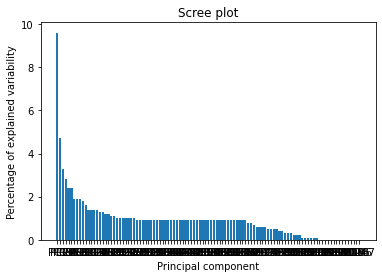

In [28]:
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of explained variability')
plt.xlabel('Principal component')
plt.title('Scree plot')
plt.show()  # grande parte da variabilidade está presente nos primeiros 9 componentes (cut-off point de 2). Estes 9 PC podem fazer uma boa representaçao geral dos dados

5. Colocar as principais coordenadas (9) numa data frame onde os rows são os samples e as colunas tem a PC label


In [31]:

#Guardar as labels das amostras numa variavel unica de modo a colocar como indice na data frame dos PCs
sample_labels = final_df.index

pca_df = pd.DataFrame(pca_data, index=[sample_labels], columns=labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
sample,,,,,,,,,,,,,,,,,,,,,
sample_24115,-3.261671,0.068190,-0.406935,-0.102007,-0.011475,-0.319752,-0.123114,0.007431,0.195398,-0.123474,...,4.586817e-16,-3.623883e-16,2.151012e-16,2.821255e-16,-1.983914e-16,8.653697e-17,1.335550e-16,-2.350574e-16,-2.608754e-16,2.189700e-17
sample_24116,-3.117421,0.055278,0.009126,-0.024119,-0.052894,-0.379348,-0.167940,-0.039418,0.258733,-0.283173,...,-1.450021e-16,6.782312e-17,5.759237e-16,-5.210515e-16,-6.308301e-17,4.907275e-16,5.863179e-16,2.992374e-16,9.741465e-18,2.404722e-16
sample_24117,-3.393739,0.076123,-0.472216,-0.257842,-0.041489,-0.541019,-0.235627,-0.011122,0.377532,-0.403303,...,7.709319e-16,-3.838774e-15,7.441919e-16,-1.587906e-15,1.988602e-16,5.115442e-16,-1.785049e-15,-2.124171e-15,3.132244e-15,6.873453e-17
sample_24118,-3.443117,0.078090,-0.356783,-0.155892,-0.005576,-0.356251,-0.113491,0.008996,0.182887,-0.213891,...,5.384790e-16,-3.068772e-16,1.353040e-16,2.907991e-16,-1.012469e-16,1.316398e-16,-1.216172e-17,-2.662824e-16,-1.914865e-16,1.495811e-17
sample_24119,-3.329425,0.071358,-0.412940,-0.095892,-0.008135,-0.323526,-0.121969,0.009194,0.195628,-0.121719,...,5.766429e-16,-3.832050e-16,1.491818e-16,3.480450e-16,-1.602275e-16,7.265918e-17,6.243139e-17,-2.940380e-16,-2.886310e-16,1.842755e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_6364,3.077301,-0.166301,0.342403,0.124112,-0.133456,-0.130396,-0.057634,-0.139835,0.085696,-0.057006,...,8.051198e-17,3.453789e-16,-4.093992e-16,-5.383987e-16,1.901866e-16,-1.008132e-16,-2.430479e-17,2.315832e-16,-1.273017e-16,3.194021e-16
sample_6365,2.736318,-0.187993,-0.170899,-0.019263,-0.050087,-0.045389,-0.004335,-0.028856,0.002307,0.005291,...,1.845954e-16,-1.750382e-16,-7.286285e-17,-1.185956e-16,1.277366e-16,-8.693538e-17,-2.376758e-16,2.688583e-17,-1.793434e-16,-5.529819e-17
sample_6366,2.743063,-0.188323,-0.176090,-0.029187,-0.058288,-0.038272,-0.003217,-0.038059,0.010756,0.004260,...,1.429620e-16,-2.027937e-16,1.179567e-16,-1.220651e-16,-5.267466e-17,-3.662840e-17,-1.752257e-16,1.032137e-16,-6.485164e-17,-9.693156e-17


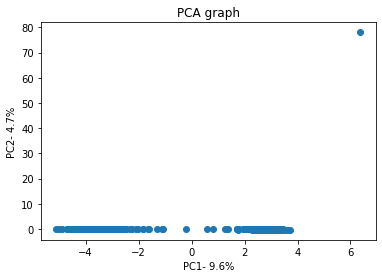

In [36]:


plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("PCA graph")
plt.xlabel('PC1- {0}%'.format(per_var[0]))
plt.ylabel('PC2- {0}%'.format(per_var[1]))
plt.show()
